In [3]:
#All Required Libraries
import os
import time
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib.cm as cm
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint #Otherwise only "odeint_adjoint"

In [46]:
#Configuration
method = 'dopri5' #RK-45
data_size = 20000
batch_time = 200
batch_size = 10
niters = 1000
test_freq = 50
viz = True
gpu = 0
#device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [48]:
#Define ODE System
omega0 = torch.tensor(2*60*np.pi)
delta1star = -0.117919635325941
omega1star = 0
delta2star = 0.094729837775605
omega2star = 0
v1star = torch.tensor(2.0)
v2star = torch.tensor(2.0)
x0 = torch.tensor([[delta1star + np.pi/6], [omega1star], [delta2star], [omega2star]]).to(device)
t = torch.arange(0.,20.,0.001).to(device)

M1 = torch.tensor(100)
D1 = torch.tensor(10)
X1 = torch.tensor(0.963)
M2 = torch.tensor(12)
D2 = torch.tensor(10)
X2 = torch.tensor(0.667)
Bred = torch.tensor(-0.583070554936976)
Gred = torch.tensor(-0.003399828308670)
Pmech1star = torch.tensor(-v1star*v2star*Bred*np.sin(delta1star - delta2star) + v1star*v2star*Gred*np.cos(delta1star-delta2star))
Pmech2star = torch.tensor(-v1star*v2star*Bred*np.sin(delta2star - delta1star) + v1star*v2star*Gred*np.cos(delta2star-delta1star))


class Real(nn.Module):
    def forward(self,t,x):
        dxdt = torch.zeros_like(x)
        dxdt[0] = x[1]
        dxdt[1] = (-D1*x[1]/omega0 + v1star*v2star*Bred*torch.sin(x[0]-x[2]) - v1star*v2star*Gred*torch.cos(x[0]-x[2]) + Pmech1star)*omega0/M1
        dxdt[2] = x[3]
        dxdt[3] = (-D2*x[3]/omega0 + v1star*v2star*Bred*torch.sin(x[2]-x[0]) - v1star*v2star*Gred*torch.cos(x[2]-x[0]) + Pmech2star)*omega0/M2
        return dxdt
    
with torch.no_grad():
    true_x = odeint(Real(), x0, t, method = method)

true_omega1 = true_x[:,1,0] / omega0
true_omega2 = true_x[:,3,0] / omega0

/var/folders/r8/rj5wxqs96474hbz0_ssrvygr0000gn/T/ipykernel_2401/3214127299.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Pmech1star = torch.tensor(-v1star*v2star*Bred*np.sin(delta1star - delta2star) + v1star*v2star*Gred*np.cos(delta1star-delta2star))
/var/folders/r8/rj5wxqs96474hbz0_ssrvygr0000gn/T/ipykernel_2401/3214127299.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Pmech2star = torch.tensor(-v1star*v2star*Bred*np.sin(delta2star - delta1star) + v1star*v2star*Gred*np.cos(delta2star-delta1star))


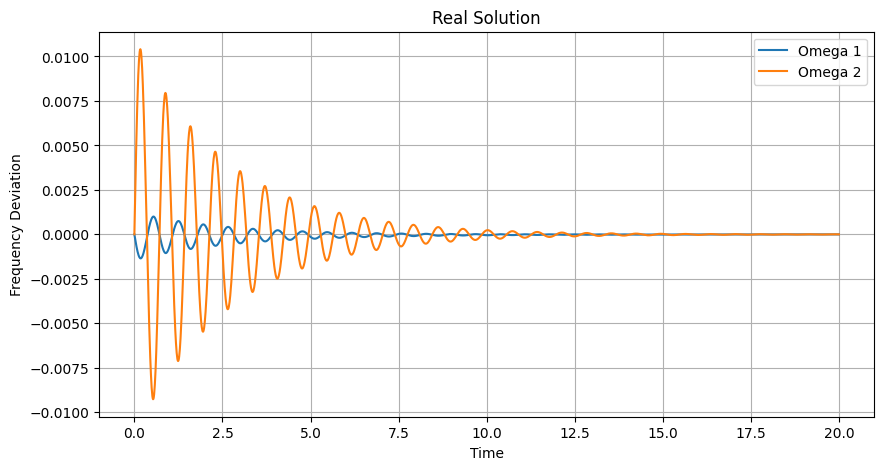

In [4]:
#Plot Correct Data
plt.figure(figsize=(10, 5))
plt.plot(t.cpu().numpy(), true_omega1.cpu().numpy(), label='Omega 1')
plt.plot(t.cpu().numpy(), true_omega2.cpu().numpy(), label='Omega 2')
plt.xlabel('Time')
plt.ylabel('Frequency Deviation')
plt.title('Real Solution')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
#Define Mini-Batches
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_x0 = true_x[s]
    batch_t = t[:batch_time]
    batch_x = torch.stack([true_x[s + i] for i in range(batch_time)], dim=0)
    return batch_x0.to(device), batch_t.to(device), batch_x.to(device)

In [20]:
#Visualization

def visualize(true_x, pred_x, odefunc, itr):
    if viz:
        fig, ((x_delta1, x_delta2), (x_omega1, x_omega2)) = plt.subplots(2, 2, figsize=(12, 8), facecolor='white')

        x_delta1.set_title('Generator 1')
        x_delta1.set_xlabel('Time [s]')
        x_delta1.set_ylabel('Rotor Angle')
        x_delta1.plot(t.cpu().numpy(), true_x.cpu().numpy()[:,0,0] / omega0, 'g-', label='True Delta 1')
        x_delta1.plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,0,0] / omega0, 'b--', label='Predicted Delta 1')
        x_delta1.legend()

        x_delta2.set_title('Generator 2')
        x_delta2.set_xlabel('Time [s]')
        x_delta2.set_ylabel('Rotor Angle')
        x_delta2.plot(t.cpu().numpy(), true_x.cpu().numpy()[:,2,0] / omega0, 'g-', label='True Delta 2')
        x_delta2.plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,2,0] / omega0, 'b--', label='Predicted Delta 2')
        x_delta2.legend()

        x_omega1.set_title('Generator 1')
        x_omega1.set_xlabel('Time [s]')
        x_omega1.set_ylabel('Frequency Deviation')
        x_omega1.plot(t.cpu().numpy(), true_x.cpu().numpy()[:,1,0] / omega0, 'g-', label='True Omega 1')
        x_omega1.plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,1,0] / omega0, 'b--', label='Predicted Omega 1')
        x_omega1.legend()

        x_omega2.set_title('Generator 2')
        x_omega2.set_xlabel('Time [s]')
        x_omega2.set_ylabel('Frequency Deviation')
        x_omega2.plot(t.cpu().numpy(), true_x.cpu().numpy()[:,3,0] / omega0, 'g-', label='True Omega 2')
        x_omega2.plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,3,0] / omega0, 'b--', label='Predicted Omega 2')
        x_omega2.legend()
        
        plt.tight_layout()
        plt.show()

"""         ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[-2:2:21j, -2:2:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag).reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")""""Ejemplo 1.ipynb"

'         ax_vecfield.set_title(\'Learned Vector Field\')\n        ax_vecfield.set_xlabel(\'x\')\n        ax_vecfield.set_ylabel(\'y\')\n\n        y, x = np.mgrid[-2:2:21j, -2:2:21j]\n        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()\n        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)\n        dydt = (dydt / mag).reshape(21, 21, 2)\n\n        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")Ejemplo 1.ipynb'

In [33]:
#NN to learn the ODE

class NeuralODE(nn.Module):
    def __init__(self, M1, D1, M2, D2, V1, V2, B, G, Pmech1, Pmech2):
        super(NeuralODE, self).__init__()
        self.M1 = M1
        self.M2 = nn.Parameter(M2)
        self.D1 = D1
        self.D2 = nn.Parameter(D2)
        self.V1 = V1
        self.V2 = V2
        #self.V2 = nn.Parameter(V2)
        self.B = B
        #self.B = nn.Parameter(B)
        self. G = G
        #self.G = nn.Parameter(G)
        self.Pmech1 = Pmech1
        self.Pmech2 = Pmech2
        #self.Pmech2 = nn.Parameter(Pmech2)
        
    def forward(self, t, y):
        dydt = torch.zeros_like(y)
        dydt[0] = y[1]
        dydt[1] = (-self.D1*y[1]/omega0 + self.V1*self.V2*self.B*torch.sin(y[0]-y[2]) - self.V1*self.V2*self.G*torch.cos(y[0]-y[2]) + self.Pmech1)*omega0/self.M1
        dydt[2] = y[3]
        dydt[3] = (-self.D2*y[3]/omega0 + self.V1*self.V2*self.B*torch.sin(y[2]-y[0]) - self.V1*self.V2*self.G*torch.cos(y[2]-y[0]) + self.Pmech2)*omega0/self.M2
        return dydt

In [22]:
#Track average and current value (loss and time).
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [51]:
#Training loop
Delta = 1 #Porcentual deviation from real value
M1_G = M1
D1_G = D1
M2_G = Delta*M2
#M2_G = torch.randint(-Delta, Delta, (1,1))/100 * M2 + M2
D2_G = Delta*D2
#D2_G = torch.randint(-Delta, Delta, (1,1))/100 * D2 + D2
V1_G = v1star
V2_G = v2star
#V2_G = Delta*v2star
#V2_G = torch.randint(-Delta, Delta, (1,1))/100 * v2star + v2star
B_G = Bred
#B_G = Delta*Bred
#B_G = torch.randint(-Delta, Delta, (1,1))/100 * Bred + Bred
G_G = Gred
#G_G = Delta*Gred
#G_G = torch.randint(-Delta, Delta, (1,1))/100 * Gred + Gred
Pmech1_G = Pmech1star
Pmech2_G = Pmech2star
#Pmech2_G = Delta*Pmech2star
#Pmech2_G = torch.randint(-Delta, Delta, (1,1))/100 * Pmech2star + Pmech2star

print(f"M1: {M1.item()}", f"M1_G: {M1_G.item()}")
print(f"D1: {D1.item()}", f"D1_G: {D1_G.item()}")
print(f"M2: {M2.item()}", f"M2_G: {M2_G.item()}")
print(f"D2: {D2.item()}", f"D2_G: {D2_G.item()}")
print(f"V1: {v1star.item()}", f"V1_G: {V1_G.item()}")
print(f"V2: {v2star.item()}", f"V2_G: {V2_G.item()}")
print(f"Bred: {Bred.item()}", f"B_G: {B_G.item()}")
print(f"Gred: {Gred.item()}", f"G_G: {G_G.item()}")
print(f"Pmech1: {Pmech1star.item()}", f"Pmech1_G: {Pmech1_G.item()}")
print(f"Pmech2: {Pmech2star.item()}", f"Pmech2_G: {Pmech2_G.item()}")


func = NeuralODE(M1_G, D1_G, M2_G, D2_G, V1_G, V2_G, B_G, G_G, Pmech1_G, Pmech2_G).to(device)
optimizer = optim.RMSprop(func.parameters(), lr=0.05) #RMSprop
end = time.time()
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)
ii = 0

with torch.no_grad():
    initial_pred = odeint(func, x0, t).to(device)
    initial_true = true_x.to(device)
    visualize(initial_true, initial_pred, func, 0)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_x0, batch_t, batch_x = get_batch()
    batch_omega1 = batch_x[:,:,1,:]
    batch_omega2 = batch_x[:,:,3,:]
    pred_x = odeint(func, batch_x0, batch_t).to(device)
    pred_omega1 = pred_x[:,:,1,:]
    pred_omega2 = pred_x[:,:,3,:]
    loss = torch.mean((pred_omega2 - batch_omega2)**2)
    #loss = 0.2*torch.mean((pred_omega1 - batch_omega1)**2) + 0.8*torch.mean((pred_omega2 - batch_omega2)**2)
    loss.backward() #Calculate the dloss/dparameters
    optimizer.step() #Update value of parameters
    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_x = odeint(func, x0, t)
            pred_omega1 = pred_x[:,1,:]/omega0
            pred_omega2 = pred_x[:,3,:]/omega0
            loss = torch.mean((pred_omega2 - true_omega2)**2)
            #loss = 0.2*torch.mean((pred_omega1 - true_omega1)**2) + 0.8*torch.mean((pred_omega2 - true_omega2)**2) #[:,:,0]
            print(f'\nIteration {itr:d} | Total Loss {loss.item():.12f}')
            print('Updated Parameters:')
            for name, param in func.named_parameters():
                print(f"{name}: {param.data}")
            visualize(true_x, pred_x, func, ii)
            ii += 1
    end = time.time()

M1: 100 M1_G: 100
D1: 10 D1_G: 10
M2: 12 M2_G: 12
D2: 10 D2_G: 10
V1: 2.0 V1_G: 2.0
V2: 2.0 V2_G: 2.0
Bred: -0.5830705761909485 B_G: -0.5830705761909485
Gred: -0.003399828216060996 G_G: -0.003399828216060996
Pmech1: -0.5055221915245056 Pmech1_G: -0.5055221915245056
Pmech2: 0.47893619537353516 Pmech2_G: 0.47893619537353516


RuntimeError: Only Tensors of floating point and complex dtype can require gradients

In [ ]:
#Complete Code
#All Required Libraries
import os
import time
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib.cm as cm
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint #Otherwise only "odeint_adjoint"

#Configuration
method = 'dopri5' #RK-45
data_size = 2000
batch_time = 100
batch_size = 20
niters = 1000
test_freq = 10
viz = True
gpu = 0
#device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
device = 'cpu'

#Define ODE System
omega0 = torch.tensor(2*60*np.pi)
delta1star = -0.117919635325941
omega1star = 0
delta2star = 0.094729837775605
omega2star = 0
v1star = torch.tensor(2.0)
v2star = torch.tensor(2.0)
x0 = torch.tensor([[delta1star + np.pi/6], [omega1star], [delta2star], [omega2star]]).to(device)
t = torch.arange(0.,20.,0.01).to(device)

M1 = torch.tensor(100)
D1 = torch.tensor(10)
X1 = torch.tensor(0.963)
M2 = torch.tensor(12)
D2 = torch.tensor(10)
X2 = torch.tensor(0.667)
Bred = torch.tensor(-0.583070554936976)
Gred = torch.tensor(-0.003399828308670)
Pmech1star = torch.tensor(-v1star*v2star*Bred*np.sin(delta1star - delta2star) + v1star*v2star*Gred*np.cos(delta1star-delta2star))
Pmech2star = torch.tensor(-v1star*v2star*Bred*np.sin(delta2star - delta1star) + v1star*v2star*Gred*np.cos(delta2star-delta1star))


class Real(nn.Module):
    def forward(self,t,x):
        dxdt = torch.zeros_like(x)
        dxdt[0] = x[1]
        dxdt[1] = (-D1*x[1]/omega0 + v1star*v2star*Bred*torch.sin(x[0]-x[2]) - v1star*v2star*Gred*torch.cos(x[0]-x[2]) + Pmech1star)*omega0/M1
        dxdt[2] = x[3]
        dxdt[3] = (-D2*x[3]/omega0 + v1star*v2star*Bred*torch.sin(x[2]-x[0]) - v1star*v2star*Gred*torch.cos(x[2]-x[0]) + Pmech2star)*omega0/M2
        return dxdt
    
with torch.no_grad():
    true_x = odeint(Real(), x0, t, method = method)

true_omega1 = true_x[:,1,0] / omega0
true_omega2 = true_x[:,3,0] / omega0

#Define Mini-Batches
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_x0 = true_x[s]
    batch_t = t[:batch_time]
    batch_x = torch.stack([true_x[s + i] for i in range(batch_time)], dim=0)
    return batch_x0.to(device), batch_t.to(device), batch_x.to(device)

#Visualization

def visualize(true_x, pred_x, odefunc, itr):
    if viz:
        fig, ((x_delta1, x_delta2), (x_omega1, x_omega2)) = plt.subplots(2, 2, figsize=(12, 8), facecolor='white')

        x_delta1.set_title('Generator 1')
        x_delta1.set_xlabel('Time [s]')
        x_delta1.set_ylabel('Rotor Angle')
        x_delta1.plot(t.cpu().numpy(), true_x.cpu().numpy()[:,0,0] / omega0, 'g-', label='True Delta 1')
        x_delta1.plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,0,0] / omega0, 'b--', label='Predicted Delta 1')
        x_delta1.legend()

        x_delta2.set_title('Generator 2')
        x_delta2.set_xlabel('Time [s]')
        x_delta2.set_ylabel('Rotor Angle')
        x_delta2.plot(t.cpu().numpy(), true_x.cpu().numpy()[:,2,0] / omega0, 'g-', label='True Delta 2')
        x_delta2.plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,2,0] / omega0, 'b--', label='Predicted Delta 2')
        x_delta2.legend()

        x_omega1.set_title('Generator 1')
        x_omega1.set_xlabel('Time [s]')
        x_omega1.set_ylabel('Frequency Deviation')
        x_omega1.plot(t.cpu().numpy(), true_x.cpu().numpy()[:,1,0] / omega0, 'g-', label='True Omega 1')
        x_omega1.plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,1,0] / omega0, 'b--', label='Predicted Omega 1')
        x_omega1.legend()

        x_omega2.set_title('Generator 2')
        x_omega2.set_xlabel('Time [s]')
        x_omega2.set_ylabel('Frequency Deviation')
        x_omega2.plot(t.cpu().numpy(), true_x.cpu().numpy()[:,3,0] / omega0, 'g-', label='True Omega 2')
        x_omega2.plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,3,0] / omega0, 'b--', label='Predicted Omega 2')
        x_omega2.legend()
        
        plt.tight_layout()
        plt.show()

#NN to learn the ODE

class NeuralODE(nn.Module):
    def __init__(self, M1, D1, M2, D2, V1, V2, B, G, Pmech1, Pmech2):
        super(NeuralODE, self).__init__()
        self.M1 = M1
        self.M2 = nn.Parameter(M2)
        self.D1 = D1
        self.D2 = nn.Parameter(D2)
        self.V1 = V1
        self.V2 = nn.Parameter(V2)
        self.B = nn.Parameter(B)
        self.G = nn.Parameter(G)
        self.Pmech1 = Pmech1
        self.Pmech2 = nn.Parameter(Pmech2)
        
    def forward(self, t, y):
        dydt = torch.zeros_like(y)
        dydt[0] = y[1]
        dydt[1] = (-self.D1*y[1]/omega0 + self.V1*self.V2*self.B*torch.sin(y[0]-y[2]) - self.V1*self.V2*self.G*torch.cos(y[0]-y[2]) + self.Pmech1)*omega0/self.M1
        dydt[2] = y[3]
        dydt[3] = (-self.D2*y[3]/omega0 + self.V1*self.V2*self.B*torch.sin(y[2]-y[0]) - self.V1*self.V2*self.G*torch.cos(y[2]-y[0]) + self.Pmech2)*omega0/self.M2
        return dydt
    
#Track average and current value (loss and time).
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

#Training loop
Delta = 0.98 #Porcentual deviation from real value
M1_G = M1
D1_G = D1
M2_G = Delta*M2
#M2_G = torch.randint(-Delta, Delta, (1,1))/100 * M2 + M2
D2_G = Delta*D2
#D2_G = torch.randint(-Delta, Delta, (1,1))/100 * D2 + D2
V1_G = v1star
V2_G = Delta*v2star
#V2_G = torch.randint(-Delta, Delta, (1,1))/100 * v2star + v2star
B_G = Delta*Bred
#B_G = torch.randint(-Delta, Delta, (1,1))/100 * Bred + Bred
G_G = Delta*Gred
#G_G = torch.randint(-Delta, Delta, (1,1))/100 * Gred + Gred
Pmech1_G = Pmech1star
Pmech2_G = Delta*Pmech2star
#Pmech2_G = torch.randint(-Delta, Delta, (1,1))/100 * Pmech2star + Pmech2star

print(f"M1: {M1.item()}", f"M1_G: {M1_G.item()}")
print(f"D1: {D1.item()}", f"D1_G: {D1_G.item()}")
print(f"M2: {M2.item()}", f"M2_G: {M2_G.item()}")
print(f"D2: {D2.item()}", f"D2_G: {D2_G.item()}")
print(f"V1: {v1star.item()}", f"V1_G: {V1_G.item()}")
print(f"V2: {v2star.item()}", f"V2_G: {V2_G.item()}")
print(f"Bred: {Bred.item()}", f"B_G: {B_G.item()}")
print(f"Gred: {Gred.item()}", f"G_G: {G_G.item()}")
print(f"Pmech1: {Pmech1star.item()}", f"Pmech1_G: {Pmech1_G.item()}")
print(f"Pmech2: {Pmech2star.item()}", f"Pmech2_G: {Pmech2_G.item()}")


func = NeuralODE(M1_G, D1_G, M2_G, D2_G, V1_G, V2_G, B_G, G_G, Pmech1_G, Pmech2_G).to(device)
optimizer = torch.optim.Adam(func.parameters(), lr = 0.01) #RMSprop
end = time.time()
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)
ii = 0

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_x0, batch_t, batch_x = get_batch()
    pred_x = odeint(func, batch_x0, batch_t).to(device)
    loss = torch.mean((pred_x - batch_x)**2) #pred_x[:,:,:,0]
    loss.backward() #Calculate the dloss/dparameters
    optimizer.step() #Update value of parameters
    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_x = odeint(func, x0, t)
            loss = torch.mean((pred_x - true_x)**2) #[:,:,0]
            print(f'\nIteration {itr:d} | Total Loss {loss.item():.6f}')
            print('Updated Parameters:')
            for name, param in func.named_parameters():
                print(f"{name}: {param.data}")
            visualize(true_x, pred_x, func, ii)
            ii += 1
    end = time.time()